In [96]:
import pandas as pd
import seaborn as srn
import statistics  as sts
import matplotlib.pyplot as plt

In [ ]:
# Inicialmente, a exploração e limpeza (se necessário) de dados.

In [11]:
dataset = pd.read_csv("car_price_dataset.csv")
dataset

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867
...,...,...,...,...,...,...,...,...,...,...
9995,Kia,Optima,2004,3.7,Diesel,Semi-Automatic,5794,2,4,8884
9996,Chevrolet,Impala,2002,1.4,Electric,Automatic,168000,2,1,6240
9997,BMW,3 Series,2010,3.0,Petrol,Automatic,86664,5,1,9866
9998,Ford,Explorer,2002,1.4,Hybrid,Automatic,225772,4,1,4084


In [13]:
dataset.shape

(10000, 10)

In [16]:
dataset.isnull().sum()

Brand           0
Model           0
Year            0
Engine_Size     0
Fuel_Type       0
Transmission    0
Mileage         0
Doors           0
Owner_Count     0
Price           0
dtype: int64

In [26]:
dataset.describe() 

,Year,Engine_Size,Mileage,Doors,Owner_Count,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,2011.543700,3.000560,149239.111800,3.497100,2.991100,8852.96440
std,6.897699,1.149324,86322.348957,1.110097,1.422682,3112.59681
min,2000.000000,1.000000,25.000000,2.000000,1.000000,2000.00000
25%,2006.000000,2.000000,74649.250000,3.000000,2.000000,6646.00000
50%,2012.000000,3.000000,149587.000000,3.000000,3.000000,8858.50000
75%,2017.000000,4.000000,223577.500000,4.000000,4.000000,11086.50000
max,2023.000000,5.000000,299947.000000,5.000000,5.000000,18301.00000


In [39]:
# Aparentemente, nenhum outlier ou dado faltante
# Agora, para análise gráfica dos dados
# O que exatamente você acha que poderia influenciar o preço de um carro?
# Bom, na verdade, todas as informações presentes parecem influenciar o preço de alguma forma

In [47]:
dataset["Price"].describe()

count    10000.00000
mean      8852.96440
std       3112.59681
min       2000.00000
25%       6646.00000
50%       8858.50000
75%      11086.50000
max      18301.00000
Name: Price, dtype: float64

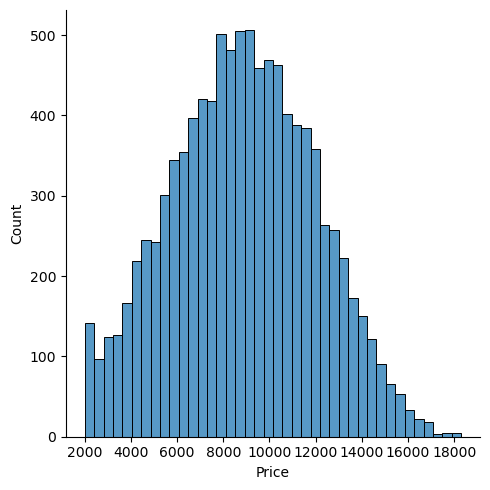

In [68]:
srn.displot(dataset['Price']);

In [74]:
print("Assimetria: %f" % dataset['Price'].skew())
print("Curtose: %f" % dataset['Price'].kurt())

Assimetria: 0.026136
Curtose: -0.481945


In [76]:
# Perfeito! Realmente não temos que nos preocupar com erros.
# Agora, vamos tentar encontrar as maiores relações com o preço

<Axes: xlabel='Year', ylabel='Price'>

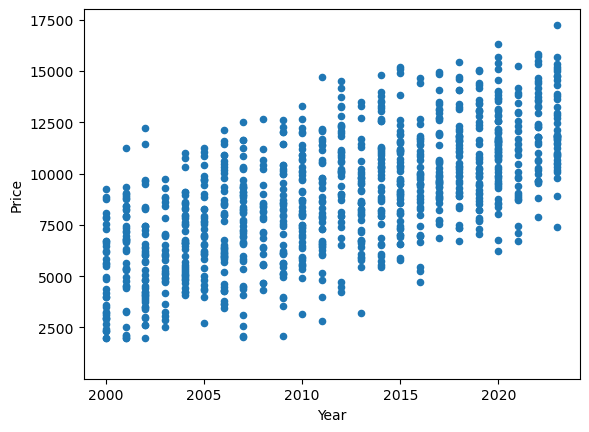

In [134]:
data = pd.concat([dataset.loc[:1000,['Price']], dataset['Year']], axis=1)
data.plot.scatter(x='Year', y='Price', ylim=(1))

<Axes: xlabel='Mileage', ylabel='Price'>

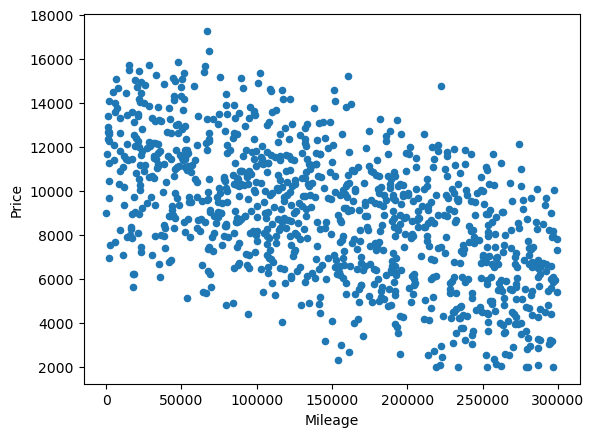

In [132]:
data = pd.concat([dataset.loc[:1000,['Price']], dataset['Mileage']], axis=1)
data.plot.scatter(x='Mileage', y='Price')

In [142]:
# Como esperado, carros mais antigos e mais rodados tendem a ser mais baratos...

In [ ]:
# Como temos variáveis categóricas, uma boa seria transformar isso em variáveis numéricas

In [88]:
ds_encoded = pd.get_dummies(dataset, columns=['Brand','Model','Fuel_Type','Transmission'], drop_first=True)
ds_encoded.shape

(10000, 49)

In [ ]:
# Não deu tão certo quanto eu imaginava... 